# 終点誤差分散最小モデル
**終点誤差分散最小モデル** (minimum-variance model; {cite:p}`Harris1998-gj`)を実装する．

$\mathbf{A}\in \mathbb{R}^{n\times n}$, $\mathbf{B}\in \mathbb{R}^{n}$とする．$\dot{x}=\mathbf{A}_{c}\mathbf{x}+\mathbf{B}_{c}(u + w)$について，差分化すると

$$
\begin{align}
\mathbf{x}(t+dt)&=\mathbf{x}(t)+\dot{\mathbf{x}}dt\\
\mathbf{x}_{t+1}&=\mathbf{I}\mathbf{x}_t+(\mathbf{A}_{c}dt)\mathbf{x}_t+(\mathbf{B}_{c}dt)(u + w)
\end{align}
$$

となる．ここで$\mathbf{I}$は単位行列である．よって $\mathbf{A}=\mathbf{I}+\mathbf{A}_{c}dt,\ \mathbf{B}=\mathbf{B}_cdt$ として

$$
\begin{equation}
\mathbf{x}_{t+1} = \mathbf{A} \mathbf{x}_t + \mathbf{B}(u_t + w_t)
\end{equation}
$$

と表せる． $\mathbf{x}_t$の平均は

$$
\begin{equation}
\mathbb{E}\left[\mathbf{x}_{t}\right]=\mathbf{A}^{t} \mathbf{x}_{0}+\sum_{i=0}^{t-1} \mathbf{A}^{t-1-i} \mathbf{B} u_{i}
\end{equation}
$$

$\mathbf{x}_t$の分散は

$$
\begin{equation}
\operatorname{Cov}\left[\mathbf{x}_{t}\right]=k \sum_{i=0}^{t-1}\left(\mathbf{A}^{t-1-i} \mathbf{B}\right)\left(\mathbf{A}^{t-1-i} \mathbf{B}\right)^{\top} u_{i}^{2}
\end{equation}
$$

となる．

## 終点誤差分散最小モデルの実装

In [1]:
using LinearAlgebra, Random, PyPlot
rc("axes.spines", top=false, right=false)

In [2]:
# Equality Constrained Quadratic Programming
function solve_quad_prog(P, q, A, b)
    """
    minimize   : 1/2 * x'*P*x + q'*x
    subject to : A*x = b
    """
    K = [P A'; A zeros(size(A)[1], size(A)[1])] # KKT matrix
    sol = K \ [-q; b]
    return sol[1:size(A)[2]]
end;

In [3]:
function minimum_variance_model(Ac, Bc, x0, xf, tf, tp, dt)
    dims = size(x0)[1]
    ntf = round(Int, tf/dt)
    ntp = round(Int, tp/dt)
    nt = ntf + ntp # total time steps    
    
    A = I(dims) + Ac * dt
    B = Bc*dt
    #A = exp(Ac*dt);
    #B = Ac^-1 * (I(dims) - A) *Bc; 
    
    # calculation of V
    diagV = zeros(nt);
    for t=0:nt-1
        if t < ntf
            diagV[t+1] = sum([(A^(k-t-1) * B * B' * A'^(k-t-1))[1,1] for k=ntf:nt-1])
        else
            diagV[t+1] = diagV[t] + (A^(nt-t-2) * B * B' * A'^(nt-t-2))[1,1]
        end
    end
    diagV /= maximum(diagV) # for numerical stability
    V = Diagonal(diagV); 
    
    # 制約条件における行列Cとベクトルdの計算
    #calculation of C
    C = zeros(dims*(ntp+1), nt);
    for p=1:ntp+1
        for q=1:nt
            if ntf-1+(p-1)-(q-1) >= 0
                idx = dims*(p-1)+1:dims*p
                C[idx, q] = A^(ntf-1-(q-1)+(p-1)) * B # if ntf-1-(q-1)+(p-1) == 0; A^(ntf-1-(q-1)+(p-1))*B equal to B
            end
        end
    end
    
    # calculation of d
    d = vcat([xf - A^(ntf+t) * x0 for t=0:ntp]...);
    
    # 制御信号を二次計画法で計算 (solution by quadratic programming)
    u = solve_quad_prog(V, zeros(nt), C, d);
    
    # 制御信号を二次計画法で計算 (forward solution)
    x = zeros(dims, nt);
    x[:,1] = x0;
    Σ = zeros(dims, dims, nt);
    Σ[:, :, 1] = B * u[1]^2 * B'
    for t=1:nt-1
        x[:,t+1] = A*x[:, t] + B*u[t] # update
        Σ[:, :, t+1] = A * Σ[:, :, t] * A' + B * u[t]^2 * B' # variance
    end
    return x, u, Σ
end

minimum_variance_model (generic function with 1 method)

In [80]:
t1 = 224*1e-3 # time const of eye dynamics (s)
t2 = 13*1e-3  # another time const of eye dynamics (s)
tm = 10*1e-3
dt = 1e-3     # simulation time step (s)
tf = 50*1e-3  # movement duration (s)
tp = 40*1e-3  # post-movement duration (s)
nt = round(Int, (tf+tp)/dt) # total time steps
trange = (1:nt) * dt * 1e3 # ms

# 2nd order
x0 = zeros(2) # initial state (pos=0, vel=0)
xf = [10, 0]  # final state (pos=10, vel=0)
Ac = [0 1; -1/(t1*t2) -1/t1-1/t2];
Bc = [0, 1]

#x0 = zeros(3)   # initial state (pos=0, vel=0, acc=0)
#xf = [10, 0, 0] # final state (pos=10, vel=0, acc=0)
#Ac = [0 1 0; 0 0 1; -1/(t1*t2*tm) -1/(t1*t2)-1/(t1*tm)-1/(t2*tm) -1/t1-1/t2-1/tm];
#Bc = [0, 0, 1/tm];


2-element Vector{Int64}:
 0
 1

In [81]:
x_opt, u_opt, Σ_opt = minimum_variance_model(Ac, Bc, x0, xf, tf, tp, dt);

In [83]:
u_opt

90-element Vector{Float64}:
 30369.854472008505
 30181.869162094703
 29990.649720641642
 29795.87620941572
 29597.199881184257
 29394.24014755196
 29186.581167783716
 28973.768003002242
 28755.302270863347
 28530.637224822793
 28299.17216905024
 28060.246104506077
 27813.130483158944
     ⋮
  3434.0659340657617
  3434.065934066069
  3434.0659340659554
  3434.0659340659486
  3434.065934065748
  3434.0659340659226
  3434.065934066118
  3434.065934066016
  3434.065934065701
  3434.0659340660222
  3434.065934065897
  3434.065934065928

結果の描画．

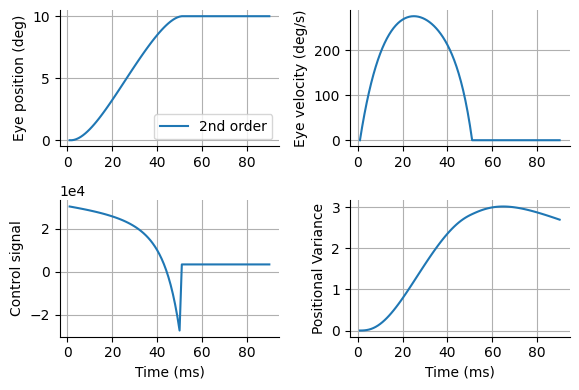

In [82]:
figure(figsize=(6, 4))
subplot(2,2,1); plot(trange, x_opt[1, :], label="2nd order")
ylabel("Eye position (deg)"); grid(); legend()
subplot(2,2,2); plot(trange, x_opt[2, :]); 
ylabel("Eye velocity (deg/s)"); grid();
subplot(2,2,3); plot(trange, u_opt);
ylabel("Control signal"); xlabel("Time (ms)"); grid();
ax = gca(); ax[:ticklabel_format](style="sci",axis="y",scilimits=(0,0))
subplot(2,2,4); plot(trange, Σ_opt[1,1,:]);
ylabel("Positional Variance"); xlabel("Time (ms)"); grid()
tight_layout()

In [67]:
function minimum_variance_model2(Ac, Bc, x0, xf, tf, tp, dt)
    dims = size(x0)[1]
    ntf = round(Int, tf/dt)
    ntp = round(Int, tp/dt)
    nt = ntf + ntp # total time steps    
    
    A = I(dims) + Ac * dt
    B = Bc*dt
    #A = exp(Ac*dt);
    #B = Ac^-1 * (I(dims) - A) *Bc; 
    
    # calculation of V
    diagV = zeros(nt);
    for t=0:nt-1
        if t < ntf
            diagV[t+1] = sum([(A^(k-t-1) * B * B' * A'^(k-t-1))[1,1] for k=ntf:nt-1])
        else
            diagV[t+1] = diagV[t] + (A^(nt-t-2) * B * B' * A'^(nt-t-2))[1,1]
        end
    end
    diagV /= maximum(diagV) # for numerical stability
    V = Diagonal(diagV); 
    
    # 制約条件における行列Cとベクトルdの計算
    #calculation of C
    C = zeros(dims*(ntp+1), nt);
    for p=1:ntp+1
        for q=1:nt
            if ntf-1+(p-1)-(q-1) >= 0
                idx = dims*(p-1)+1:dims*p
                C[idx, q] = A^(ntf-1-(q-1)+(p-1)) * B # if ntf-1-(q-1)+(p-1) == 0; A^(ntf-1-(q-1)+(p-1))*B equal to B
            end
        end
    end
    
    # calculation of d
    d = vcat([xf - A^(ntf+t) * x0 for t=0:ntp]...);
    return C, d
end

minimum_variance_model2 (generic function with 1 method)

In [68]:
C, d =  minimum_variance_model2(Ac, Bc, x0, xf, tf, tp, dt);
u = C \ d;

In [69]:
size(C)

(82, 90)

In [70]:
size(d)

(82,)

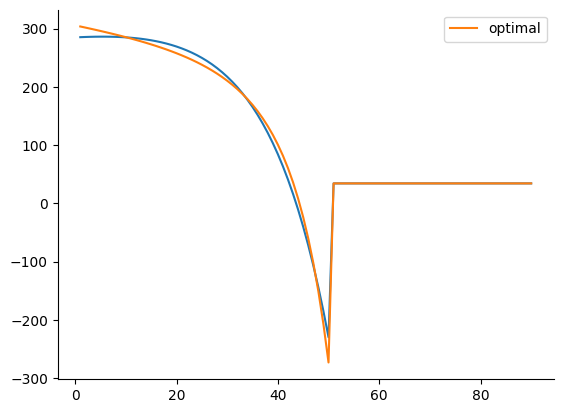

PyObject <matplotlib.legend.Legend object at 0x000001F5CF2088F0>

In [71]:
plot(trange, u)
plot(trange, u_opt, label="optimal");
legend()

In [72]:
function minimum_variance_model3(Ac, Bc, u, x0, xf, tf, tp, dt)
    dims = size(x0)[1]
    ntf = round(Int, tf/dt)
    ntp = round(Int, tp/dt)
    nt = ntf + ntp # total time steps    
    
    A = I(dims) + Ac * dt
    B = Bc*dt
    
    # 制御信号を二次計画法で計算 (forward solution)
    x = zeros(dims, nt);
    x[:,1] = x0;
    Σ = zeros(dims, dims, nt);
    Σ[:, :, 1] = B * u[1]^2 * B'
    for t=1:nt-1
        x[:,t+1] = A*x[:, t] + B*u[t] # update
        Σ[:, :, t+1] = A * Σ[:, :, t] * A' + B * u[t]^2 * B' # variance
    end
    return x, Σ
end

minimum_variance_model3 (generic function with 1 method)

In [73]:
x, Σ =  minimum_variance_model3(Ac, Bc, u, x0, xf, tf, tp, dt);

In [74]:
dims = size(x0)[1]
ntf = round(Int, tf/dt)
ntp = round(Int, tp/dt)
nt = ntf + ntp # total time steps   

90

In [75]:
ntp

40

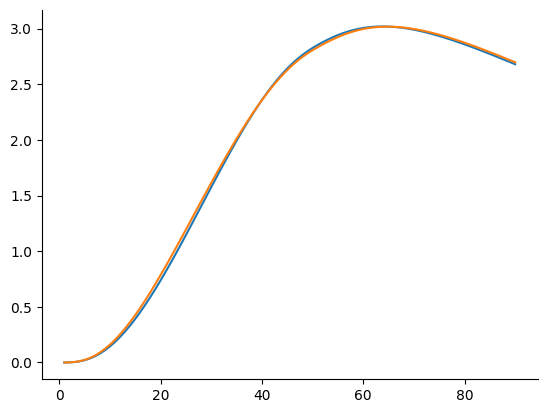

In [76]:
plot(trange, Σ[1,1,:]);
plot(trange, Σ_opt[1,1,:]);

In [77]:
sum(Σ[1,1, ntf+1:end])

116.3944456907929

In [78]:
sum(Σ[2,2, ntf:end])

12139.399362142318

In [79]:
sum(Σ_opt[1,1, ntf+1:end])

116.51677978865425

In [61]:
sum(Σ_opt[2,2, ntf:end])

46817.79140112046

In [62]:
sum((x[1, ntf:end] .- 10) .^2)

3.406797804633017e-5

In [63]:
sum((x_opt[1, ntf:end] .- 10) .^2)

7.261172528806294e-5

In [28]:
sum((x[1, ntf:end] .- 10) .^2)

0.0008255702338574076

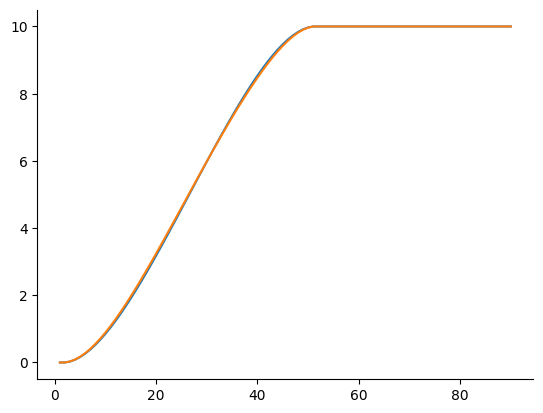

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x000001F5CCFB9BB0>

In [29]:
plot(trange, x[1, :])
plot(trange, x_opt[1, :], label="2nd order")

## 参考文献
```{bibliography}
:filter: docname in docnames
```